In [89]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Softmax
import random
import numpy as np
import gym
import math
import copy
from collections import deque
from matplotlib import pyplot as plt
#!pip install box2d

In [54]:
class ReplayBuffer:

  def __init__(self, n=1, max_size=1_000_000):
    self.buffer = []
    self.max_size = max_size
    self.n = n
    self.ctr = 0
    self.filled = False
  
  def add(self, s, a, r, s1, d):
    if not self.filled:
      self.buffer.append((s, a, r, s1, d))
      if self.ctr == self.max_size - 1:
        self.filled = True
    else:
      if self.ctr == self.max_size:
        self.ctr = 0
      self.buffer[self.ctr] = (s, a, r, s1, d)
    self.ctr += 1
    
  def sample(self, batch_size):
    if len(self.buffer) < batch_size:
      return self.buffer
    else:
      return random.sample(self.buffer, batch_size)

In [88]:
class DQN:

  def __init__(self, env, opt=None, loss=None, epsilon_init=1, 
               epsilon_decay=0.995, epsilon_min=0.1, multiply_epsilon=True, batch_size=32,
               buffer_length=1_000_000, gamma=0.95, model=None, double=False,
               update_freq=None, noisy=False, distributional=False, z=None,
               v_min=None, v_max=None, n_atoms=None, n_step=1):
    self.env = env
    self.obs_dim = env.observation_space.shape
    self.act_dim = env.action_space.n
    self.epsilon = epsilon_init
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.model = self.build_model(model)
    self.buffer = ReplayBuffer(max_size=buffer_length, n=n_step)
    self.batch_size = batch_size
    self.gamma = gamma
    self.double = double
    self.noisy = noisy
    self.distributional = distributional
    self.n_step = n_step
    self.multiply_epsilon = multiply_epsilon

    if opt is None:
      self.optimizer = tf.keras.optimizers.Adam()
    else:
      self.optimizer = opt

    if loss is None:
      self.loss = tf.keras.losses.MSE
    else:
      self.loss = loss

    if double:
      self.target_model = self.build_model(model)
      assert (update_freq is not None)
      self.update_freq = update_freq
    
    if distributional:
      assert (z is not None)
      assert (v_min is not None)
      assert (v_max is not None)
      assert (n_atoms is not None)
      self.z = z
      self.v_min = v_min
      self.v_max = v_max
      self.n_atoms = n_atoms
      self.dz = (self.v_max - self.v_min) / (self.n_atoms - 1)
  
  def build_model(self, model):
    if model is None:
      inp = tf.keras.Input(self.obs_dim)
      x = Dense(24, activation="relu")(inp)
      x = Dense(24, activation="relu")(x)
      out = Dense(self.act_dim)(x)
      return tf.keras.Model(inputs=inp, outputs=out)
    else:
      return model
  
  def act(self, x, decay=True):
    if self.noisy:
      return np.argmax(np.squeeze(self.model(x.reshape(1, 4)).numpy()))
    else:
      if np.random.random() < self.epsilon:
        if decay:
          self.decay_epsilon()
        return random.randrange(self.act_dim)
      else:
        if decay:
          self.decay_epsilon()
        if self.distributional:
          out = np.vstack(self.model(x.reshape((1, 4))))
          q = np.sum(np.multiply(out, self.z), axis=1)
          return np.argmax(q)
        else:
          return np.argmax(np.squeeze(self.model(x[np.newaxis, :]).numpy()))

  def decay_epsilon(self):
    if self.multiply_epsilon:
      self.epsilon *= self.epsilon_decay
    else:
      self.epsilon -= self.epsilon_decay
    self.epsilon = max(self.epsilon, self.epsilon_min)
  
  def backward(self, x, y, actions):
    if self.distributional:
      with tf.GradientTape() as tape:
        loss = self.loss(tf.stop_gradient(y), self.model(x))
      grad = tape.gradient(loss, self.model.trainable_weights)
      self.optimizer.apply_gradients(zip(grad, self.model.trainable_weights))
    else:
      with tf.GradientTape() as tape:
        loss = self.loss(tf.stop_gradient(y), tf.reduce_sum(
            self.model(x) * actions, axis=1))
      grad = tape.gradient(loss, self.model.trainable_weights)
      self.optimizer.apply_gradients(zip(grad, self.model.trainable_weights))
  
  def update_target(self):
    self.target_model.set_weights(self.model.get_weights())
  
  def train(self, games):
    reward_list = []
    total_steps = 0
    for game in range(games):
      s = self.env.reset()
      step_ctr = 0
      d = False
      game_reward = 0
      while not d:
        if self.double and (total_steps == self.update_freq):
          self.update_target()
          total_steps = 0
        if self.noisy:
          for layer in self.model.layers:
            if isinstance(layer, NoisyDense):
              layer.unfreeze_epsilon()
        a = self.act(s)
        if self.noisy:
          for layer in self.model.layers:
            if isinstance(layer, NoisyDense):
              layer.freeze_epsilon()
        s1, r, d, _ = self.env.step(a)
        game_reward += r
        self.buffer.add(s, a, r, s1, d)
        s = s1
        s1 = None
        
        # Experience replay
        exp = self.buffer.sample(self.batch_size)
        states = np.array([i[0] for i in exp])
        actions = np.array([i[1] for i in exp])
        rewards = np.array([i[2] for i in exp])
        nexts = np.array([i[3] for i in exp])
        dones = np.array([i[4] for i in exp])
        if self.distributional:
          ### This implementation is from https://github.com/marload/DistRL-TensorFlow2/blob/master/C51/C51.py
          z = self.model(nexts)
          z_concat = np.vstack(z)
          q = np.sum(np.multiply(z_concat, self.z), axis=1)
          q = q.reshape((len(exp), self.act_dim), order="F")
          next_actions = np.argmax(q, axis=1)
          m_prob = [np.zeros((len(exp), self.n_atoms)) for _ in range(self.act_dim)]
          for i in range(len(exp)):
            if dones[i]:
              Tz = min(self.v_max, max(self.v_min, rewards[i]))
              bj = (Tz - self.v_min) / self.dz
              l, u = math.floor(bj), math.ceil(bj)
              m_prob[actions[i]][i][int(l)] += (u - bj)
              m_prob[actions[i]][i][int(u)] += (bj - l)
            else:
              for j in range(self.n_atoms):
                Tz = min(self.v_max, max(self.v_min, rewards[i] + self.gamma * self.z[j]))
                bj = (Tz - self.v_min) / self.dz
                l, u = math.floor(bj), math.ceil(bj)
                m_prob[actions[i]][i][int(l)] += z[next_actions[i]][i][j] * (u - bj)
                m_prob[actions[i]][i][int(u)] += z[next_actions[i]][i][j] * (bj - l)
          ###
          z_cpy = [i.numpy() for i in z]
          for i in range(len(exp)):
            z_cpy[actions[i]][i] = m_prob[actions[i]][i]
          self.backward(states, z_cpy, None)
          
        else:
          if self.double:
            target_q = self.target_model(nexts)
          else:
            target_q = self.model(nexts)
          targets = rewards + tf.math.reduce_max(tf.transpose(tf.transpose(self.gamma * target_q) * (1 - dones)), axis=1)
          one_hot = tf.one_hot(actions, self.act_dim)
          self.backward(states, targets, one_hot)
        step_ctr += 1
        total_steps += 1
      reward_list.append(game_reward)
      print("Game: %d, Total Reward: %f, Epsilon: %f" % (game + 1, game_reward, self.epsilon))
    return reward_list

In [71]:
env = gym.make("CartPole-v1")
dqn = DQN(env)
dqn.train(500)

Game: 1, Total Reward: 22.000000, Epsilon: 0.895587
Game: 2, Total Reward: 14.000000, Epsilon: 0.834893
Game: 3, Total Reward: 20.000000, Epsilon: 0.755253
Game: 4, Total Reward: 24.000000, Epsilon: 0.669648
Game: 5, Total Reward: 13.000000, Epsilon: 0.627403
Game: 6, Total Reward: 14.000000, Epsilon: 0.584884
Game: 7, Total Reward: 22.000000, Epsilon: 0.523814
Game: 8, Total Reward: 15.000000, Epsilon: 0.485874
Game: 9, Total Reward: 10.000000, Epsilon: 0.462120
Game: 10, Total Reward: 10.000000, Epsilon: 0.439527
Game: 11, Total Reward: 20.000000, Epsilon: 0.397600
Game: 12, Total Reward: 11.000000, Epsilon: 0.376271
Game: 13, Total Reward: 12.000000, Epsilon: 0.354305
Game: 14, Total Reward: 11.000000, Epsilon: 0.335298
Game: 15, Total Reward: 12.000000, Epsilon: 0.315725
Game: 16, Total Reward: 8.000000, Epsilon: 0.303315
Game: 17, Total Reward: 11.000000, Epsilon: 0.287043
Game: 18, Total Reward: 10.000000, Epsilon: 0.273010
Game: 19, Total Reward: 10.000000, Epsilon: 0.259662
Gam

KeyboardInterrupt: ignored

In [ ]:
env = gym.make("CartPole-v1")
def get_dueling(env):
  inp = tf.keras.Input(env.observation_space.shape)
  x = Dense(24, activation="relu")(inp)
  x = Dense(24, activation="relu")(x)
  value = Dense(1)(x)
  advantage = Dense(env.action_space.n)(x)
  out = value + (advantage - tf.reduce_max(advantage))
  dueling_model = tf.keras.Model(inputs=inp, outputs=out)
  dueling_dqn = DQN(env, model=dueling_model)
  return dueling_dqn
dueling_dqn = get_dueling(env)
dueling_dqn.train(500)

Game: 1, Total Reward: 22.000000, Epsilon: 0.895587
Game: 2, Total Reward: 14.000000, Epsilon: 0.834893
Game: 3, Total Reward: 14.000000, Epsilon: 0.778313
Game: 4, Total Reward: 9.000000, Epsilon: 0.743981
Game: 5, Total Reward: 17.000000, Epsilon: 0.683210
Game: 6, Total Reward: 14.000000, Epsilon: 0.636909
Game: 7, Total Reward: 15.000000, Epsilon: 0.590777
Game: 8, Total Reward: 17.000000, Epsilon: 0.542520
Game: 9, Total Reward: 9.000000, Epsilon: 0.518589
Game: 10, Total Reward: 22.000000, Epsilon: 0.464442
Game: 11, Total Reward: 10.000000, Epsilon: 0.441735
Game: 12, Total Reward: 12.000000, Epsilon: 0.415948
Game: 13, Total Reward: 13.000000, Epsilon: 0.389708
Game: 14, Total Reward: 17.000000, Epsilon: 0.357875
Game: 15, Total Reward: 25.000000, Epsilon: 0.315725
Game: 16, Total Reward: 13.000000, Epsilon: 0.295807
Game: 17, Total Reward: 31.000000, Epsilon: 0.253235
Game: 18, Total Reward: 10.000000, Epsilon: 0.240855
Game: 19, Total Reward: 10.000000, Epsilon: 0.229079
Game

KeyboardInterrupt: ignored

In [ ]:
env = gym.make("CartPole-v1")
def get_double(env):
  double_dqn = DQN(env, double=True, update_freq=50)
  return double_dqn
double_dqn = get_double(env)
double_dqn.train(500)

Game: 1, Total Reward: 29.000000, Epsilon: 0.864708
Game: 2, Total Reward: 8.000000, Epsilon: 0.830719
Game: 3, Total Reward: 20.000000, Epsilon: 0.751477
Game: 4, Total Reward: 54.000000, Epsilon: 0.573274
Game: 5, Total Reward: 13.000000, Epsilon: 0.537108
Game: 6, Total Reward: 14.000000, Epsilon: 0.500709
Game: 7, Total Reward: 11.000000, Epsilon: 0.473848
Game: 8, Total Reward: 9.000000, Epsilon: 0.452946
Game: 9, Total Reward: 10.000000, Epsilon: 0.430802
Game: 10, Total Reward: 10.000000, Epsilon: 0.409740
Game: 11, Total Reward: 11.000000, Epsilon: 0.387759
Game: 12, Total Reward: 12.000000, Epsilon: 0.365123
Game: 13, Total Reward: 13.000000, Epsilon: 0.342089
Game: 14, Total Reward: 11.000000, Epsilon: 0.323738
Game: 15, Total Reward: 14.000000, Epsilon: 0.301798
Game: 16, Total Reward: 10.000000, Epsilon: 0.287043
Game: 17, Total Reward: 13.000000, Epsilon: 0.268935
Game: 18, Total Reward: 11.000000, Epsilon: 0.254508
Game: 19, Total Reward: 9.000000, Epsilon: 0.243281
Game:

KeyboardInterrupt: ignored

In [ ]:
class NoisyDense(tf.keras.layers.Layer):

  def __init__(self, units, input_dim, activation=tf.identity, factorised=False):
    super(NoisyDense, self).__init__()
    self.factorised = factorised
    self.activation = activation
    self.units = units
    self.input_dim = input_dim
    if factorised:
      self.mu_initializer = tf.keras.initializers.RandomUniform(-np.sqrt(1 / input_dim), np.sqrt(1 / input_dim))
      self.sigma_initializer = tf.keras.initializers.Constant(value=0.5 / np.sqrt(input_dim))
    else:
      self.mu_initializer = tf.keras.initializers.RandomUniform(-np.sqrt(3 / input_dim), np.sqrt(3 / input_dim))
      self.sigma_initializer = tf.keras.initializers.Constant(value=0.2) # 0.017
    self.mu_w = tf.Variable(initial_value=self.mu_initializer(shape=(input_dim, units)), trainable=True)
    self.mu_b = tf.Variable(initial_value=self.mu_initializer(shape=(units,)), trainable=True)
    self.sigma_w = tf.Variable(initial_value=self.sigma_initializer(shape=(input_dim, units)), trainable=True)
    self.sigma_b = tf.Variable(initial_value=self.sigma_initializer(shape=(units)), trainable=True)
    self.frozen = False
  
  def process_noise(self, noise):
    return tf.multiply(tf.sign(noise), tf.pow(tf.abs(noise), 0.5))

  def call(self, inputs):
    if self.factorised:
      if not self.frozen:
        self.epsilon_i = self.process_noise(tf.random.normal(shape=(self.input_dim,)))
        self.epsilon_j = self.process_noise(tf.random.normal(shape=(self.units,)))
        self.epsilon_ij = tf.tensordot(self.epsilon_i, self.epsilon_j, axes=0)
      z = tf.matmul(inputs, self.mu_w + self.sigma_w * self.epsilon_ij) + self.mu_b + self.sigma_b * self.epsilon_j
    else:
      if not self.frozen:
        self.epsilon_mu = self.process_noise(tf.random.normal((self.input_dim, self.units)))
        self.epsilon_b = self.process_noise(tf.random.normal((self.units,)))
      z = tf.matmul(inputs, self.mu_w + self.sigma_w * self.epsilon_mu) + self.mu_b + self.sigma_b * self.epsilon_b
    return self.activation(z)
  
  def freeze_epsilon(self):
    self.frozen = True
  
  def unfreeze_epsilon(self):
    self.frozen = False

  def get_epsilon(self):
    if self.factorised:
      return self.epsilon_i, self.epsilon_j, self.epsilon_ij
    else:
      return self.epsilon_mu, self.epsilon_b
  
  def set_epsilon(self, epsilon):
    if self.factorised:
      self.epsilon_i = epsilon[0]
      self.epsilon_j = epsilon[1]
      self.epsilon_ij = epsilon[2]
    else:
      self.epsilon_mu = epsilon[0]
      self.epsilon_b = epsilon[1]

In [ ]:
env = gym.make("CartPole-v1")
def get_noisy(env, factorised=False):
  inp = tf.keras.Input(env.observation_space.shape)
  x = NoisyDense(24, env.observation_space.shape[0], factorised=factorised, activation=tf.keras.activations.relu)(inp)
  x = NoisyDense(24, 24, factorised=factorised, activation=tf.keras.activations.relu)(x)
  out = NoisyDense(env.action_space.n, 24, factorised=factorised)(x)
  noisy_model = tf.keras.Model(inputs=inp, outputs=out)
  noisy_dqn = DQN(env, model=noisy_model, noisy=True)
  return noisy_dqn
noisy_dqn = get_noisy(env, factorised=False)
noisy_dqn.train(500)

Game: 1, Total Reward: 18.000000, Epsilon: 1.000000
Game: 2, Total Reward: 15.000000, Epsilon: 1.000000
Game: 3, Total Reward: 27.000000, Epsilon: 1.000000
Game: 4, Total Reward: 26.000000, Epsilon: 1.000000
Game: 5, Total Reward: 17.000000, Epsilon: 1.000000
Game: 6, Total Reward: 13.000000, Epsilon: 1.000000
Game: 7, Total Reward: 18.000000, Epsilon: 1.000000
Game: 8, Total Reward: 11.000000, Epsilon: 1.000000
Game: 9, Total Reward: 15.000000, Epsilon: 1.000000
Game: 10, Total Reward: 10.000000, Epsilon: 1.000000
Game: 11, Total Reward: 11.000000, Epsilon: 1.000000
Game: 12, Total Reward: 12.000000, Epsilon: 1.000000
Game: 13, Total Reward: 12.000000, Epsilon: 1.000000
Game: 14, Total Reward: 23.000000, Epsilon: 1.000000
Game: 15, Total Reward: 11.000000, Epsilon: 1.000000
Game: 16, Total Reward: 11.000000, Epsilon: 1.000000
Game: 17, Total Reward: 9.000000, Epsilon: 1.000000
Game: 18, Total Reward: 14.000000, Epsilon: 1.000000
Game: 19, Total Reward: 11.000000, Epsilon: 1.000000
Gam

KeyboardInterrupt: ignored

In [ ]:
N_ATOMS = 5
V_MIN = 0
V_MAX = 4
env = gym.make("CartPole-v1")
def get_distributional(env, n_atoms, v_min, v_max):
  z = np.array([V_MIN + i * (V_MAX - V_MIN) / (N_ATOMS - 1) for i in range(N_ATOMS)])
  inp = tf.keras.Input(env.observation_space.shape)
  x = Dense(12, activation="relu")(inp)
  x = Dense(12, activation="relu")(x)
  out = [Dense(N_ATOMS, activation="softmax")(x) for _ in range(env.action_space.n)]
  distributional_model = tf.keras.Model(inputs=inp, outputs=out)
  distributional_dqn = DQN(env, loss=tf.keras.losses.CategoricalCrossentropy(), model=distributional_model, distributional=True, v_max=V_MAX, v_min=V_MIN, z=z, n_atoms=N_ATOMS)
  return distributional_dqn
distributional_dqn = get_distributional(env, N_ATOMS, V_MIN, V_MAX)
distributional_dqn.train(500)

Game: 1, Total Reward: 25.000000, Epsilon: 0.882220
Game: 2, Total Reward: 53.000000, Epsilon: 0.676395
Game: 3, Total Reward: 23.000000, Epsilon: 0.602742
Game: 4, Total Reward: 15.000000, Epsilon: 0.559084
Game: 5, Total Reward: 14.000000, Epsilon: 0.521195
Game: 6, Total Reward: 16.000000, Epsilon: 0.481027
Game: 7, Total Reward: 12.000000, Epsilon: 0.452946
Game: 8, Total Reward: 19.000000, Epsilon: 0.411799
Game: 9, Total Reward: 11.000000, Epsilon: 0.389708
Game: 10, Total Reward: 12.000000, Epsilon: 0.366958
Game: 11, Total Reward: 11.000000, Epsilon: 0.347272
Game: 12, Total Reward: 15.000000, Epsilon: 0.322119
Game: 13, Total Reward: 31.000000, Epsilon: 0.275760
Game: 14, Total Reward: 10.000000, Epsilon: 0.262278
Game: 15, Total Reward: 11.000000, Epsilon: 0.248208
Game: 16, Total Reward: 11.000000, Epsilon: 0.234893
Game: 17, Total Reward: 8.000000, Epsilon: 0.225660
Game: 18, Total Reward: 16.000000, Epsilon: 0.208269
Game: 19, Total Reward: 36.000000, Epsilon: 0.173882
Gam

KeyboardInterrupt: ignored

In [59]:
class PERBuffer: #TODO: keep a numpy array of the probs, keep track of the minimum

  def __init__(self, max_len=1_000_000):
    self.samples = deque()
    self.probs = deque()
    self.max = 1
    self.sum = 0
    self.max_len = max_len
  
  def add(self, s, a, r, s1, d):
    self.samples.append((s, a, r, s1, d))
    self.probs.append(self.max)
    self.sum += self.max
    if len(self.samples) > self.max_len:
      self.sum -= self.probs.popleft()
      self.samples.popleft()
  
  def set(self, idx, val):
    if val > self.max:
      self.max = val
    self.sum += val - self.probs[idx]
    reset_max = False
    if self.probs[idx] == self.max:
      reset_max = True
    self.probs[idx] = val
    if reset_max:
      self.max = max(self.probs)
  
  def sample(self, size):
    if size > len(self.samples):
      return None
    else:
      p = np.array(self.probs, dtype=np.float32)
      p /= p.sum()
      p /= p.sum()
      indices = np.random.choice(np.arange(len(self.samples)), size=size, replace=False, p=p)
      samples = [self.samples[i] for i in indices]
      probs = np.array([self.probs[i] for i in indices])
      div_probs = probs / self.sum
      return samples, indices, div_probs

In [87]:
class PERDQN:

  def __init__(self, env, opt=None, loss=None, epsilon_init=1, 
               epsilon_decay=0.995, epsilon_min=0.1, epsilon_op="multiply", batch_size=32,
               buffer_length=1_000_000, gamma=0.95, model=None, alpha=1, beta=0.5, replay_freq=1, w=True):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.act_dim = env.action_space.n
    self.opt = self.set_opt(opt)
    self.loss = self.set_loss(loss)
    self.epsilon_init = epsilon_init
    self.epsilon = epsilon_init
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.epsilon_op = epsilon_op
    self.batch_size = batch_size
    self.gamma = gamma
    self.buffer = PERBuffer(max_len=buffer_length)
    self.model = self.set_model(model)
    self.alpha = alpha
    self.beta = beta

    self.replay_freq = replay_freq
    self.w = w
  
  def set_opt(self, opt):
    if opt is None:
      return tf.keras.optimizers.Adam()
    else:
      return opt
  
  def set_loss(self, loss):
    if loss is None:
      return tf.keras.losses.MSE
    else:
      return loss
  
  def set_model(self, model):
    if model is None:
      inp = tf.keras.Input(self.obs_dim)
      x = Dense(24, activation="relu")(inp)
      x = Dense(24, activation="relu")(x)
      out = Dense(self.act_dim)(x)
      return tf.keras.Model(inputs=inp, outputs=out)
    else:
      return model
  
  def decay_epsilon(self):
    if self.epsilon_op == "multiply":
      self.epsilon *= self.epsilon_decay
    else:
      self.epsilon -= self.epsilon_decay
    self.epsilon = max(self.epsilon, self.epsilon_min)
  
  def act(self, x):
    if np.random.random() < self.epsilon:
      self.decay_epsilon()
      return self.env.action_space.sample()
    else:
      self.decay_epsilon()
      pred = self.model(x[np.newaxis, :])
      return np.argmax(pred)
  
  def train(self, episodes): # maybe increase learning rate to balance out the weight
    reward_list = []
    total_steps = 0
    for episode in range(episodes):
      s = self.env.reset()
      d = False
      s1 = None
      game_reward = 0
      while not d:
        a = self.act(s)
        s1, r, d, _ = self.env.step(a)
        game_reward += r
        if total_steps % self.replay_freq == 0 and len(self.buffer.samples) >= self.batch_size:
          delta = []
          for j in range(self.batch_size):
            sample, index, prob = self.buffer.sample(1)
            sample = sample[0]
            index = index[0]
            prob = prob[0]
            if self.w:
              w = ((len(self.buffer.samples) * prob) ** -self.beta) / ((len(self.buffer.samples) * min(self.buffer.probs) / self.buffer.sum) ** -self.beta)
            else:
              w = 1
            action_one_hot = np.zeros((1, self.act_dim))
            action_one_hot[0, sample[1]] = 1
            action_one_hot = tf.constant(action_one_hot, dtype=tf.float32)
            with tf.GradientTape() as tape:
              pred = self.model(sample[0][np.newaxis, :])
              pred *= action_one_hot
              if sample[4]:
                loss = self.loss(tf.constant(sample[2]), tf.reduce_sum(pred, axis=1))
              else:
                loss = self.loss(tf.constant(sample[2] + self.gamma * np.amax(np.squeeze(self.model(sample[3][np.newaxis, :])))), tf.reduce_sum(pred, axis=1))
            grad = tape.gradient(loss, self.model.trainable_weights)
            self.buffer.set(index, loss ** self.alpha)
            if delta == []:
              for i in grad:
                delta.append(w * i)
            else:
              for i, v in enumerate(grad):
                delta[i] += w * grad[i]
          self.opt.apply_gradients(zip(delta, self.model.trainable_weights))
        total_steps += 1
        self.buffer.add(s, a, r, s1, d)
        s = s1
        s1 = None
      reward_list.append(game_reward)
      print("Episode: %d, Reward: %f, Epsilon: %f" % (episode + 1, game_reward, self.epsilon))
    return reward_list

In [ ]:
dqn = PERDQN(gym.make("CartPole-v1"))
dqn.train(200)

In [85]:
class NStepDQN:

  def __init__(self, env, opt=None, loss=None, epsilon_init=1, 
               epsilon_decay=0.995, epsilon_min=0.1, epsilon_op="multiply", batch_size=32,
               buffer_length=1_000_000, gamma=0.95, model=None, n_step=5):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.act_dim = env.action_space.n
    self.opt = self.set_opt(opt)
    self.loss = self.set_loss(loss)
    self.epsilon_init = epsilon_init
    self.epsilon = epsilon_init
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.epsilon_op = epsilon_op
    self.batch_size = batch_size
    self.gamma = gamma
    self.buffer = ReplayBuffer(max_size=buffer_length)
    self.model = self.set_model(model)
    self.n_step = n_step
  
  def set_opt(self, opt):
    if opt is None:
      return tf.keras.optimizers.Adam()
    else:
      return opt
  
  def set_loss(self, loss):
    if loss is None:
      return tf.keras.losses.MSE
    else:
      return loss
  
  def set_model(self, model):
    if model is None:
      inp = tf.keras.Input(self.obs_dim)
      x = Dense(24, activation="relu")(inp)
      x = Dense(24, activation="relu")(x)
      out = Dense(self.act_dim)(x)
      return tf.keras.Model(inputs=inp, outputs=out)
    else:
      return model
  
  def decay_epsilon(self):
    if self.epsilon_op == "multiply":
      self.epsilon *= self.epsilon_decay
    else:
      self.epsilon -= self.epsilon_decay
    self.epsilon = max(self.epsilon, self.epsilon_min)
  
  def act(self, x):
    if np.random.random() < self.epsilon:
      self.decay_epsilon()
      return self.env.action_space.sample()
    else:
      self.decay_epsilon()
      pred = self.model(x)
      return np.argmax(pred)
  
  def train(self, episodes):
    reward_list = []
    for episode in range(episodes):
      states = deque()
      rewards = deque()
      actions = deque()
      states.append(self.env.reset())
      rewards.append(0)
      actions.append(0)
      d = False
      game_reward = 0
      while not d:
        a = self.act(states[-1][np.newaxis, :])
        s1, r, d, _ = self.env.step(a)
        game_reward += r
        states.append(s1)
        rewards.append(r)
        actions.append(a)
        if len(states) > self.n_step:
          states.popleft()
          rewards.popleft()
          actions.popleft()
        if len(states) == self.n_step:
          S = states[0]
          S1 = states[-1]
          R = 0
          for i in range(self.n_step):
            R += rewards[i] * (self.gamma ** i)
          A = actions[0]
          D = d
          self.buffer.add(S, A, R, S1, D)
        if len(self.buffer.buffer) >= self.batch_size:
          exp = self.buffer.sample(self.batch_size)
          states_ = np.array([i[0] for i in exp])
          actions_ = np.array([i[1] for i in exp])
          rewards_ = np.array([i[2] for i in exp])
          nexts_ = np.array([i[3] for i in exp])
          dones_ = np.array([i[4] for i in exp])
          target_q = self.model(nexts_)
          one_hot = tf.one_hot(actions_, self.act_dim)
          targets = rewards_ + tf.math.reduce_max(tf.transpose(tf.transpose((self.gamma ** self.n_step) * target_q) * (1 - dones_)), axis=1)
          with tf.GradientTape() as tape:
            loss = self.loss(targets, tf.reduce_sum(self.model(states_) * one_hot, axis=1))
          grad = tape.gradient(loss, self.model.trainable_weights)
          self.opt.apply_gradients(zip(grad, self.model.trainable_weights))
      reward_list.append(game_reward)
      print("Game: %d, Reward: %f, Epsilon: %f" % (episode + 1, game_reward, self.epsilon))
    return reward_list

In [ ]:
dqn = NStepDQN(gym.make("CartPole-v1"), epsilon_decay=0.999)
dqn.train(200)

Game: 1, Total Reward: 22.000000, Epsilon: 0.895587
Game: 2, Total Reward: 21.000000, Epsilon: 0.806107
Game: 3, Total Reward: 14.000000, Epsilon: 0.751477
Game: 4, Total Reward: 12.000000, Epsilon: 0.707608
Game: 5, Total Reward: 8.000000, Epsilon: 0.679794
Game: 6, Total Reward: 10.000000, Epsilon: 0.646559
Game: 7, Total Reward: 9.000000, Epsilon: 0.618039
Game: 8, Total Reward: 16.000000, Epsilon: 0.570407
Game: 9, Total Reward: 14.000000, Epsilon: 0.531751
Game: 10, Total Reward: 19.000000, Epsilon: 0.483445
Game: 11, Total Reward: 13.000000, Epsilon: 0.452946
Game: 12, Total Reward: 15.000000, Epsilon: 0.420139
Game: 13, Total Reward: 12.000000, Epsilon: 0.395612
Game: 14, Total Reward: 11.000000, Epsilon: 0.374390
Game: 15, Total Reward: 11.000000, Epsilon: 0.354305
Game: 16, Total Reward: 9.000000, Epsilon: 0.338677
Game: 17, Total Reward: 9.000000, Epsilon: 0.323738
Game: 18, Total Reward: 12.000000, Epsilon: 0.304839
Game: 19, Total Reward: 16.000000, Epsilon: 0.281345
Game: 

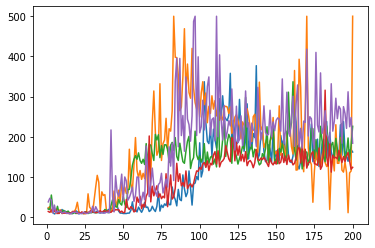

In [97]:
%matplotlib inline
def train_and_plot(class_object, env, episodes, runs):
  losses = []
  for _ in range(runs):
    losses.append(class_object(env).train(episodes))
  for i in losses:
    plt.plot(range(1, episodes + 1), i)
  plt.show()

train_and_plot(DQN, gym.make("CartPole-v1"), 200, 5)
################################################
# NONE OF THE CODE AFTER THIS CELL IS FUNCTIONAL #
################################################

In [94]:
"""
class RainbowDQN:

  def __init__(self, env, v_min=0, v_max=10, n_atoms=11, opt=None, loss=None, 
               batch_size=32, buffer_length=1_000_000, gamma=0.95, model=None,
               update_freq=50, n_step=1, replay_freq=1, alpha=1, beta=1,
               factorised=False):
    self.env = env
    self.obs_dim = env.observation_space.shape
    self.act_dim = env.action_space.n
    self.update_freq = update_freq
    self.buffer = PERBuffer(max_len=buffer_length)
    
    self.batch_size = batch_size
    self.gamma = gamma
    self.n_step = n_step
    self.v_min = v_min
    self.v_max = v_max
    self.n_atoms = n_atoms
    self.dz = (v_max - v_min)/(n_atoms - 1)
    self.z = np.array([v_min + i * self.dz for i in range(n_atoms)])
    self.factorised = factorised
    self.model = self.build_model(model)
    self.target_model = self.build_model(model)
    self.replay_freq = replay_freq
    self.alpha = alpha
    self.beta = beta
    

    if opt is None:
      self.optimizer = tf.keras.optimizers.Adam()
    else:
      self.optimizer = opt

    if loss is None:
      self.loss = tf.keras.losses.CategoricalCrossentropy()
    else:
      self.loss = loss
  
  def build_model(self, model):
    if model is None:
      inp = tf.keras.Input(self.obs_dim[0], dtype="float32")
      x = NoisyDense(24, self.obs_dim[0], activation=tf.keras.activations.relu, factorised=self.factorised)(inp)
      x = NoisyDense(24, 24, activation=tf.keras.activations.relu, factorised=self.factorised)(x)
      out = []
      for i in range(self.n_atoms):
        value = NoisyDense(1, 24, factorised=self.factorised)(x)
        advantage = NoisyDense(self.act_dim, 24, factorised=self.factorised)(x)
        out.append(Softmax()(value + advantage - tf.reduce_mean(advantage)))
      return tf.keras.Model(inputs=inp, outputs=out) # [n_atoms, batch_size, act_dim]
    else:
      return model
  
  def act(self, x):
    out = np.squeeze(np.array(self.model(x[np.newaxis, :])))
    expected_values = np.dot(out.T, self.z)
    return np.argmax(expected_values)
  
  def update_target(self):
    self.target_model.set_weights(self.model.get_weights())
  
  def train(self, episodes): # TODO: try copying wasserstein onto output of the network instead of the whole one hot deal
    total_steps = 0
    for episode in range(episodes):
      states = deque()
      actions = deque()
      rewards = deque()
      states.append(self.env.reset())
      rewards.append(0)
      actions.append(0)
      d = False
      game_reward = 0
      while not d:
        for layer in self.model.layers:
            if isinstance(layer, NoisyDense):
              layer.unfreeze_epsilon()
        a = self.act(states[-1])
        for layer in self.model.layers:
            if isinstance(layer, NoisyDense):
              layer.freeze_epsilon()
        s, r, d, _ = self.env.step(a)
        game_reward += r
        if len(states) == self.n_step:
          self.compile_samples(states, actions, rewards, d)
        self.push_observation(states, actions, rewards, s, a, r)
        if total_steps % self.replay_freq == 0 and len(self.buffer.samples) >= self.batch_size:
          samples, indices, probs = self.buffer.sample(self.batch_size)
          #w_i = (1 / self.batch_size * 1 / probs) ** self.beta
          #w_j = (self.batch_size * probs) ** -self.beta / np.amax(w_i)
          m, actions_, states_ = self.wasserstein_metric(samples)
          actions_one_hot = [np.zeros((self.batch_size, self.act_dim)) for i in range(self.n_atoms)]
          for i in range(len(actions)):
            for j in actions_one_hot:
              j[i, actions[i]] = 1
          self.backward(states_.astype('float32'), m, actions_one_hot)
        if total_steps % self.update_freq == 0:
          self.update_target()
        total_steps += 1
      print("Game: %d, Total Reward: %f" % (episode + 1, game_reward))
    
  def backward(self, samples, m, actions):
    with tf.GradientTape() as tape:
      q = self.model(samples)
      q_reduced = []
      for i in range(len(q)):
        q_reduced.append(tf.reduce_sum(q[i] * tf.constant(actions[i], dtype="float32"), axis=1))
      loss = self.loss(tf.stop_gradient(m), q_reduced)
    grad = tape.gradient(loss, self.model.trainable_weights)
    self.optimizer.apply_gradients(zip(grad, self.model.trainable_weights))

  def compile_samples(self, states, actions, rewards, done):
    S = states[0]
    S1 = states[-1]
    A = actions[0]
    D = done
    R = 0
    for i in range(len(rewards)):
      R += rewards[i] * (self.gamma ** i)
    self.buffer.add(S, A, R, S1, D)
  
  def push_observation(self, states, actions, rewards, s, a, r):
    states.append(s)
    actions.append(a)
    rewards.append(r)
    if len(states) > self.n_step:
      states.popleft()
      actions.popleft()
      rewards.popleft()
  
  def wasserstein_metric(self, samples):
    states = np.array([i[0] for i in samples], dtype=np.float32)
    actions = np.array([i[1] for i in samples])
    rewards = np.array([i[2] for i in samples])
    nexts = np.array([i[3] for i in samples])
    dones = np.array([i[4] for i in samples])
    m = [np.zeros((self.batch_size,), dtype=np.float32) for i in range(self.n_atoms)]
    q = np.stack(self.target_model(nexts))
    expected_values = np.zeros((self.batch_size, self.act_dim))
    for b in range(self.batch_size):
      for a in range(self.act_dim):
        expected_values[b, a] = np.dot(self.z, q[:, b, a])
    a_star = np.argmax(expected_values, axis=1)
    for i in range(len(states)):
      if dones[i]:
        Tz = max(self.v_min, min(self.v_max, rewards[i]))
        b_j = (Tz - self.v_min) / self.dz
        l = math.floor(b_j)
        u = math.ceil(b_j)
        m[int(l)][i] += (u - b_j)
        m[int(u)][i] += (b_j - l)
      else:
        for j in range(len(self.z)):
          Tz = max(self.v_min, min(self.v_max, rewards[i] + (self.gamma ** self.n_step) * self.z[j]))
          b_j = (Tz - self.v_min) / self.dz
          l = math.floor(b_j)
          u = math.ceil(b_j)
          m[int(l)][i] += q[j, i, a_star[i]] * (u - b_j)
          m[int(u)][i] += q[j, i, a_star[i]] * (b_j - l)
    return m, actions, states
        
dqn = RainbowDQN(gym.make("CartPole-v1"), n_step=5, replay_freq=1, n_atoms=5, v_max=4)
dqn.train(500) 
#print(np.array(dqn.model(np.ones((10, 4)))).shape)
"""

'\nclass RainbowDQN:\n\n  def __init__(self, env, v_min=0, v_max=10, n_atoms=11, opt=None, loss=None, \n               batch_size=32, buffer_length=1_000_000, gamma=0.95, model=None,\n               update_freq=50, n_step=1, replay_freq=1, alpha=1, beta=1,\n               factorised=False):\n    self.env = env\n    self.obs_dim = env.observation_space.shape\n    self.act_dim = env.action_space.n\n    self.update_freq = update_freq\n    self.buffer = PERBuffer(max_len=buffer_length)\n    \n    self.batch_size = batch_size\n    self.gamma = gamma\n    self.n_step = n_step\n    self.v_min = v_min\n    self.v_max = v_max\n    self.n_atoms = n_atoms\n    self.dz = (v_max - v_min)/(n_atoms - 1)\n    self.z = np.array([v_min + i * self.dz for i in range(n_atoms)])\n    self.factorised = factorised\n    self.model = self.build_model(model)\n    self.target_model = self.build_model(model)\n    self.replay_freq = replay_freq\n    self.alpha = alpha\n    self.beta = beta\n    \n\n    if opt is No

In [ ]:
arr = np.array([1, 2, 3, 4, 5])
print(arr[np.newaxis, :].shape)
V_MIN = 0
V_MAX = 10
DZ = 1
N_ATOMS = 6
BATCH_SIZE = 5
GAMMA = 0.5
ACTIONS = 2


rewards = np.random.randint(0, 10, size=(BATCH_SIZE,))
dones = np.random.randint(0, 2, size=(BATCH_SIZE,))
actions = np.random.randint(0, ACTIONS, size=(BATCH_SIZE,))
dones_stacked = np.vstack([dones for _ in range(N_ATOMS)]).T
z = np.array([1, 2, 3, 4, 5, 6])
in_between = (1 - dones_stacked) * GAMMA * z
Tz = in_between + rewards[:, np.newaxis]
Tz = np.maximum(V_MIN, np.minimum(V_MAX, Tz))
bj = (Tz - V_MIN) / DZ
l = np.floor(bj)
u = np.ceil(bj)
#m_prob = np.array([np.zeros((BATCH_SIZE, N_ATOMS)) for _ in range(ACTIONS)])
#m_prob[actions.reshape(BATCH_SIZE, 1), :, l.astype(int)] += (u - bj)
m_prob = np.arange(ACTIONS * BATCH_SIZE * N_ATOMS).reshape((ACTIONS, BATCH_SIZE, N_ATOMS))
print(m_prob)
print(actions)
print(l)
print(m_prob[actions.reshape(BATCH_SIZE, 1), :, l.astype(int)])
print(u - bj)

# One 6, row of u - bj should be added to each 5x6 matrix of m_prob[...]
# In other words, (u - bj)[i, j] gets added to m_prob[...][j, :, i]
# To test, compare to the for-loop algorithm

"""
print("rewards:", rewards)
print("dones:", dones)
print("actions:", actions)
print("z:", z)
print("in_between:", in_between)
print("Tz:", Tz)
print("bj:", bj)
print("l:", l)
print("u:", u)
"""


(1, 5)
[[[ 0  1  2  3  4  5]
  [ 6  7  8  9 10 11]
  [12 13 14 15 16 17]
  [18 19 20 21 22 23]
  [24 25 26 27 28 29]]

 [[30 31 32 33 34 35]
  [36 37 38 39 40 41]
  [42 43 44 45 46 47]
  [48 49 50 51 52 53]
  [54 55 56 57 58 59]]]
[0 1 0 1 1]
[[ 8.  8.  8.  8.  8.  8.]
 [ 5.  5.  5.  5.  5.  5.]
 [ 4.  5.  5.  6.  6.  7.]
 [ 7.  8.  8.  9.  9. 10.]
 [ 5.  5.  5.  5.  5.  5.]]


IndexError: ignored

In [ ]:
arr = np.random.randint(0, 11, size=(5, 10))
print(arr)
print(arr[np.array([[0, 1, 3, 4],[0, 1, 3, 4]]), np.array([[0, 0, 0, 0],[1, 1, 1, 1]])])


[[10  8  3  6  1 10 10  4  5  5]
 [ 9  9  6  0  4  6  1  8  3  9]
 [ 4  3  8  8  3  2  5  8 10  7]
 [10  8  2 10  5  0  7 10  9  0]
 [ 2  4  2  7  8  5  5  4  7  7]]
[[10  9 10  2]
 [ 8  9  8  4]]


In [ ]:
v_min = 0
v_max = 5
n_atoms = 6
i = 2
dz = 1
z = np.array([0, 1, 2, 3, 4, 5]) # self.z
Z = [np.random.randint(0, 5, size=(10, 6)) for _ in range(2)] # z
next_actions = np.array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])
gamma = 0.5
m_prob = np.zeros((2, 10, 6))
actions = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
rewards = np.array([5, 6, 2, 3, 4, 5, 0, 9, 8, 2])

In [ ]:
%%time
for j in range(n_atoms):
  Tz = min(v_max, max(v_min, rewards[i] + gamma * z[j]))
  bj = (Tz - v_min) / dz
  l, u = math.floor(bj), math.ceil(bj)
  m_prob[actions[i]][i][int(l)] += Z[next_actions[i]][i][j] * (u - bj)
  m_prob[actions[i]][i][int(u)] += Z[next_actions[i]][i][j] * (bj - l)

CPU times: user 202 µs, sys: 0 ns, total: 202 µs
Wall time: 211 µs


In [ ]:
%%time
Tz = np.minimum(v_max, np.maximum(v_min, rewards[i] + gamma * z))
bj = (Tz - v_min) / dz
l = np.floor(bj)
u = np.ceil(bj)
np.add.at(m_prob, (actions[i], i, l.astype(int)), Z[next_actions[i]][i] * (u - bj))
np.add.at(m_prob, (actions[i], i, u.astype(int)), Z[next_actions[i]][i] * (bj - l))

CPU times: user 351 µs, sys: 0 ns, total: 351 µs
Wall time: 245 µs


In [ ]:
tensor = tf.constant([1, 2, 3, 4, 5])
tensor.numpy()[0] = 10
print(tensor)

tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32)


In [ ]:
arr1 = np.random.randint(low=0, high=3, size=(5, 2))
arr2 = np.random.randint(low=0, high=3, size=(5,))
print(arr1)
print(arr2)
print(np.dot(arr1.T, arr2))

[[1 2]
 [1 0]
 [1 0]
 [2 2]
 [0 1]]
[1 0 0 1 0]
[3 4]


In [ ]:
arr = np.array([np.random.randint(0, 3, size=(10, 2)) for i in range(5)])
z = np.array([1, 2, 3, 4, 5])
print(arr.shape)
d = np.dot(arr.T, z)
expected_values = np.zeros((10, 2))
for b in range(10):
  for a in range(2):
    expected_values[b, a] = np.dot(arr[:, b, a], z)
print(expected_values.shape)
print(np.argmax(expected_values, axis=1).shape)

(5, 10, 2)
(10, 2)
(10,)


In [ ]:
arr = [np.random.randint((4, 2)) for i in range(5)]
oh = [np.array([[0, 1], [1, 0], [0, 1], [1, 0]]) for i in range(5)]
# 5, 4, 2 -> 5, 4
#print([i for i in arr])
print([arr[i] * oh[i] for i in range(5)])
arr2 = [arr[i] * oh[i] for i in range(5)]
arr3 = []
for i in range(len(arr2)):
  arr3.append(np.sum(arr2[i], axis=1))
print(arr3)

[array([[0, 0],
       [2, 0],
       [0, 0],
       [2, 0]]), array([[0, 0],
       [3, 0],
       [0, 0],
       [3, 0]]), array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0]]), array([[0, 0],
       [3, 0],
       [0, 0],
       [3, 0]]), array([[0, 1],
       [2, 0],
       [0, 1],
       [2, 0]])]
[array([0, 2, 0, 2]), array([0, 3, 0, 3]), array([1, 1, 1, 1]), array([0, 3, 0, 3]), array([1, 2, 1, 2])]
